In [2]:
from typing import Callable
import torch
import matplotlib.pyplot as plt

class CustomSSM:

    def __init__(self, z_function: Callable, q=0.001, r=0.05):
        self.z_function = z_function
        self.q = q
        self.r = r

    def z_dist(self, zt: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=z_function(zt),
                                                      covariance_matrix=self.q * torch.eye(zt.shape[-1]))
    
    def y_dist(self, zt: torch.Tensor):
        return torch.distributions.MultivariateNormal(loc=zt,
                                                      covariance_matrix=self.r * torch.eye(zt.shape[-1]))

    def sample_y(self, zt_next):
        p_y = self.y_dist(zt_next)
        yt_next = p_y.sample()
        return yt_next

    def sample_z(self, zt):
        p_z = self.z_dist(zt)
        zt_next = p_z.sample()
        return zt_next
    
    def _step(self, zt = torch.tensor([1.5, 0.0])):
        zt_next = self.sample_z(zt)
        yt_next = self.sample_y(zt_next)
        return zt_next, torch.stack((zt_next, yt_next))
    
    def samples(self, z0, N_s = 100):
        def scan(func, init_values, length):
            carry = init_values
            logs_chain = []
            for i in range(length):
                carry, logs = func(carry)
                logs_chain.append(logs)
            logs_output = torch.stack(logs_chain,dim=1)
            return carry, logs_output
       
        _, logs_chain = scan(self._step, z0, N_s)
        # (zt,yt)
        return logs_chain
    
def z_function(z, delta=0.4):
    z_x = z[0] + delta * torch.sin(z[1])
    z_y = z[1] + delta * torch.cos(z[0])
    return torch.cat((torch.unsqueeze(z_x,0), torch.unsqueeze(z_y,0)))

torch.Size([2, 100, 2])
torch.Size([2, 100, 2])
torch.Size([2, 100, 2])
torch.Size([2, 100, 2])
torch.Size([2, 100, 2])
tensor([[[ 1.4122e+00,  1.4597e-02],
         [ 1.4578e+00,  1.3432e-01],
         [ 1.4604e+00,  9.7787e-02],
         [ 1.4973e+00,  1.2920e-01],
         [ 1.5746e+00,  1.5906e-01],
         [ 1.6725e+00,  1.6399e-01],
         [ 1.7847e+00,  8.1527e-02],
         [ 1.8137e+00, -2.2173e-02],
         [ 1.8393e+00, -1.2364e-01],
         [ 1.7824e+00, -2.0976e-01],
         [ 1.7198e+00, -2.9788e-01],
         [ 1.6338e+00, -3.2608e-01],
         [ 1.5317e+00, -3.7040e-01],
         [ 1.4230e+00, -3.8571e-01],
         [ 1.3113e+00, -3.7735e-01],
         [ 1.1794e+00, -2.9114e-01],
         [ 1.0259e+00, -1.3704e-01],
         [ 1.0311e+00,  5.4178e-02],
         [ 1.0947e+00,  2.5292e-01],
         [ 1.1988e+00,  4.2211e-01],
         [ 1.3532e+00,  5.4166e-01],
         [ 1.5544e+00,  6.1679e-01],
         [ 1.7877e+00,  6.7275e-01],
         [ 2.0445e+00,  5.999

<Axes: title={'center': 'custom linear gaussian state space model'}>

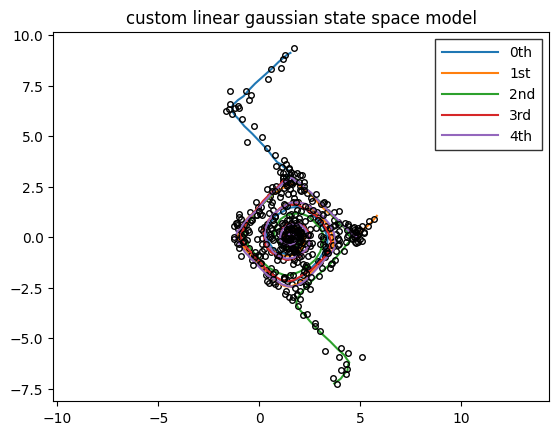

In [4]:
model = CustomSSM(z_function)
z0 = torch.tensor([1.5, 0.0])

def plot_inference(N_s, samples, estimates=None, est_type="", ax=None, title="", aspect=0.8, show_states=True):
    lines = []
    for i in range(N_s):
        states, emissions = samples[i][0], samples[i][1]
        if ax is None:
            fig, ax = plt.subplots()
        if show_states:
            line, = ax.plot(*states.T, label="True States")
            lines.append(line)
        ax.plot(*emissions.T, "ok", fillstyle="none", ms=4, label="Observations")
        if estimates is not None:
            ax.plot(*estimates.T, color="r", linewidth=1.5, label=f"{est_type} Estimate")
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k", handles=lines,
              labels=['0th','1st','2nd','3rd','4th'])
    #ax.set_aspect(aspect)
    ax.set_title(title)
    ax.axis('equal')
    return ax
total_samples = []
for _ in range(5):
    samples = model.samples(z0, 100)
    print(samples.shape)
    total_samples.append(samples)
print(total_samples[-1])
plot_inference(5, total_samples, title='custom linear gaussian state space model')

In [46]:
from typing import NamedTuple


class Constants(NamedTuple):
    phi: torch.Tensor = torch.tensor([0.9])
    q: torch.Tensor = torch.tensor([10.0])
    beta: torch.Tensor = torch.tensor([0.5])
    r: torch.Tensor = torch.tensor([1.0])

init_constants = Constants()

class GaussianSequenceModel:

    def __init__(self, init_constants: Constants):
        self.init_constants = init_constants
    
    def sample_z_step(self, prev_zt):
        phi = self.init_constants.phi
        q = self.init_constants.q
        zt = torch.distributions.Normal(loc=phi*prev_zt, scale=torch.sqrt(q)).sample()
        return zt

    def y_step(self, prev_y_mu_t, zt):
        beta = self.init_constants.beta
        r = self.init_constants.r
        mu_t = torch.vmap(lambda mu_i,z_i_t : beta*mu_i+z_i_t)(prev_y_mu_t,zt)
        y_t_dist = torch.distributions.Normal(loc=mu_t, scale=torch.sqrt(r))
        return mu_t, y_t_dist

    def sample_y_step(self, prev_y_mu_t, zt):
        mu_t, y_t_dist = self.y_step(prev_y_mu_t, zt)
        y_t = y_t_dist.sample()
        return mu_t.ravel(), y_t.ravel()
    
    def sample_step(self, prev_zt, prev_y_mu_t):
        zt = self.sample_z_step(prev_zt)
        mu_t, y_t = self.sample_y_step(prev_y_mu_t,zt)

        return (zt, mu_t), torch.cat((zt.unsqueeze(0), y_t.unsqueeze(0)))
    
    def sample(self, nsteps, N_s=1):
        mu_0, z_i_0 = self.inits(N_s)
        init_values = (mu_0,z_i_0)
        def scan(func, init_values, length):
            carry = init_values
            logs_chain = []
            for i in range(length):
                carry, logs = func(carry[0], carry[1])
                logs_chain.append(logs)
            logs_output = torch.stack(logs_chain,dim=1)
            return carry, logs_output
        _, logs_chain = scan(self.sample_step, init_values, nsteps)
        return logs_chain

    def inits(self, N_s):
        mu_0 = torch.zeros(N_s)
        z_i_0 = torch.zeros(N_s)
        return mu_0,z_i_0
    
    def sequential_importance_sampling(self, y_ts, T, N_s=10, sis=True):
        q = self.init_constants.q
        _, z_i_0 = self.inits(N_s)
        z_i_t = self.sample_z_step(z_i_0)
        w_i_1 = y_ts[0] / z_i_t
        W_i_1 = w_i_1 / w_i_1.sum()
        normalized_posterior_1 = (W_i_1*torch.abs(z_i_t.mean()-z_i_t)).sum()
        posteriors, normalized_w, latents = [], [], []
        latents.append(z_i_t)
        posteriors.append(normalized_posterior_1)
        normalized_w.append(W_i_1)
        for t in range(1,T):
            z_i_t = self.sample_z_step(z_i_t)
            incremental_weight = y_ts[t]
            log_unnormalized_weight = w_i_1*incremental_weight
            log_normalized_weight = log_unnormalized_weight / log_unnormalized_weight.sum()
            normalized_w.append(log_normalized_weight)
            normalized_posterior_t = (log_normalized_weight*torch.abs(z_i_t.mean()-z_i_t)).sum()
            posteriors.append(normalized_posterior_t)
            latents.append(z_i_t)
        return posteriors, torch.stack(normalized_w)
    

particles = 5
T = 100
model = GaussianSequenceModel(init_constants)
samples = model.sample(T, N_s=particles)
print('sample (zts, yts) shape', samples.shape)
# y_ts = samples[1]
# print('only yts shape : ',y_ts.shape)
# SIS
# posteriors_sis, weights_sis = model.sequential_importance_sampling(y_ts, T, N_s=5, sis=True)
# SISR
# posteriors_smc, weights_smc = model.sequential_importance_sampling(y_ts, T, N_s=5, sis=False)
# print(weights_sis)
# print('---------------')
# print(weights_smc)

sample (zts, yts) shape torch.Size([2, 100, 5])


torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
tensor([[[ 1.5045e+00,  1.1025e-01],
         [ 1.5184e+00,  9.7052e-02],
         [ 1.5530e+00,  1.5577e-01],
         [ 1.6076e+00,  1.9829e-01],
         [ 1.6623e+00,  2.0988e-01],
         [ 1.7608e+00,  1.4170e-01],
         [ 1.8119e+00,  7.4857e-02],
         [ 1.9061e+00, -7.8168e-02],
         [ 1.8691e+00, -2.0520e-01],
         [ 1.7732e+00, -3.4636e-01]],

        [[ 1.7544e+00, -1.1192e-03],
         [ 1.5893e+00, -1.1315e-01],
         [ 1.8297e+00,  1.1553e-01],
         [ 1.2496e+00,  3.5940e-02],
         [ 1.8132e+00,  2.7027e-01],
         [ 1.5850e+00, -1.7748e-01],
         [ 2.0535e+00, -1.0487e-01],
         [ 2.0918e+00,  1.1732e-01],
         [ 1.9993e+00,  4.2184e-01],
         [ 1.7037e+00, -1.0337e-01]]])


<Axes: title={'center': 'custom linear gaussian state space model'}>

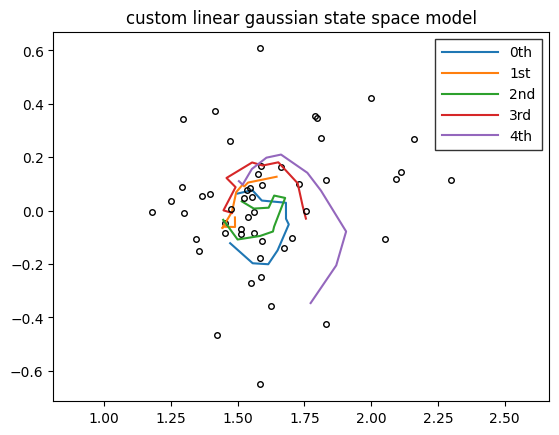

In [49]:
model = CustomSSM(z_function)
z0 = torch.tensor([1.5, 0.0])

def plot_inference(N_s, samples, estimates=None, est_type="", ax=None, title="", aspect=0.8, show_states=True):
    lines = []
    for i in range(N_s):
        states, emissions = samples[i][0], samples[i][1]
        if ax is None:
            fig, ax = plt.subplots()
        if show_states:
            line, = ax.plot(*states.T, label="True States")
            lines.append(line)
        ax.plot(*emissions.T, "ok", fillstyle="none", ms=4, label="Observations")
        if estimates is not None:
            ax.plot(*estimates.T, color="r", linewidth=1.5, label=f"{est_type} Estimate")
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k", handles=lines,
              labels=['0th','1st','2nd','3rd','4th'])
    #ax.set_aspect(aspect)
    ax.set_title(title)
    ax.axis('equal')
    return ax
total_samples = []
for _ in range(5):
    samples = model.samples(z0, 10)
    print(samples.shape)
    total_samples.append(samples)
print(total_samples[-1])
plot_inference(5, total_samples, title='custom linear gaussian state space model')


In [16]:
import matplotlib.pyplot as plt

def plot_sis_weights(hist, n_steps, spacing=1.5, max_size=0.3):
    """
    Plot the evolution of weights in the sequential importance sampling (SIS) algorithm.

    Parameters
    ----------
    weights: array(n_particles, n_steps)
        Weights at each time step.
    n_steps: int
        Number of steps to plot.
    spacing: float
        Spacing between particles.
    max_size: float
        Maximum size of the particles.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect(1)
    weights_subset = hist[:n_steps]
    for col, weights_row in enumerate(weights_subset):
        norm_cst = weights_row.sum()
        radii = weights_row / norm_cst * max_size
        for row, rad in enumerate(radii):
            if col != n_steps - 1:
                plt.arrow(spacing * (col + 0.25), row, 0.6, 0, width=0.05,
                          edgecolor="white", facecolor="tab:gray")
            circle = plt.Circle((spacing * col, row), rad, color="tab:red")
            ax.add_artist(circle)

    plt.xlim(-1, n_steps * spacing)
    plt.xlabel("Iteration (t)")
    plt.ylabel("Particle index (i)")

    xticks_pos = torch.arange(0, n_steps * spacing - 1, 2)
    xticks_lab = torch.arange(1, n_steps + 1)
    plt.xticks(xticks_pos, xticks_lab)

    return fig, ax

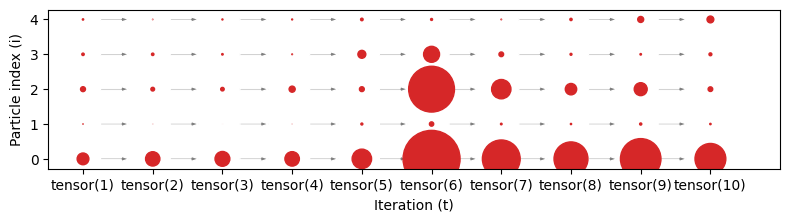

In [17]:
spacing = 2
fig, ax = plot_sis_weights(weights_sis, n_steps=10, spacing=spacing)
plt.tight_layout()

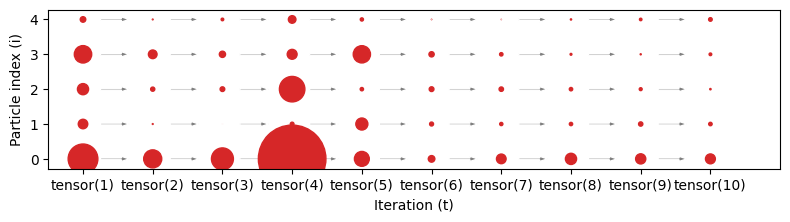

In [18]:
fig, ax = plot_sis_weights(weights_smc, n_steps=10, spacing=spacing)
plt.tight_layout()

<Axes: title={'center': 'custom linear gaussian state space model'}>

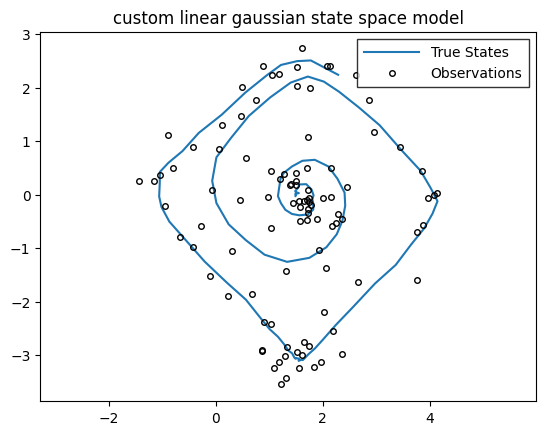

In [28]:
# bootstrap_result = torch.stack(posteriors_sis)
plot_inference(samples[0],samples[1],title='custom linear gaussian state space model')